# The Meme Stock Phenomenon: An Analysis of Wall Street Bets

Wall Street Bets (WSB) is a stock trading forum on the social media website Reddit. In early 2021, users of WSB drove the purchase price of GameStop up from \\$20 a share to nearly $500. GameStop was just the first of many “meme stocks,” stocks that have gained a cult-like following via social media.Although there have been other meme stock successes such as AMC and BB (Blackberry Limited), there have also been meme stocks that haven’t quite achieved the same sort of short squeeze success. These include stocks such as BBBY (Bed Bath and Beyond Inc.) and HOOD (Robinhood Markets Inc.). Could these differences in outcomes be explained by the enthusiasm, or lack thereof, of the community behind the meme stocks? 

The three questions I am looking to answer in this analysis are:
1. Are the sentiments of social media posts a good indicator of the future performance of meme stocks?

2. Are there differences in the sentiment of posts about successful meme stocks (pre short squeeze) versus unsuccessful meme stocks?

3. Is there a critical mass of social media community size (based on number of unique posters) that leads to meme stock success?

The data used in this analysis was extracted from Reddit using the Python packages [PSAW](https://psaw.readthedocs.io/en/latest/) and [PRAW](https://praw.readthedocs.io/en/stable/). Stock data was pulled from [Stooq](https://stooq.com/).

To understand how the sentiments of social media posts affect the future performance of a stock, I will need to aggregate sentiment scores and calculate a forward rolling average of stock prices. Then I will need to check if there is a correlation between the sentiment scores and the rolling averages.

I have calculated sentiment scores in two ways: using the [VADER model](https://www.nltk.org/_modules/nltk/sentiment/vader.html) provided as a module in the Python package NLTK, and using the [Twitter-roBERTa-base-sentiment model](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) available on Hugging Face Hub by Cardiff NLP. VADER, which stands for Valence Aware Dictionary for Sentiment Reasoning, is a dictionary-based approach that maps lexical features to sentiment scores. The Twitter-roBERTa-base-sentiment model, which I will refer to as roBERTa from here on out, is a transformer-based neural network trained on 58 million tweets. It is available along with a tokenizer that transforms input text into embeddings. 

Sentiment score within my dataset is a categorical variable. A post can either be classified as `negative`, `neutral` or `positive`. These classifications represent the most probable class returned by the sentiment analysis models. In order to aggregate sentiment scores, I will transform them into the numerical values -1, 0, and 1 for `negative`, `neutral` or `positive` respectively.

In [1]:
from typing import List

from dotenv import load_dotenv
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import psycopg2
import seaborn as sns
from scipy.stats import ttest_ind, ranksums
from statsmodels.tsa.stattools import grangercausalitytests

from analysis import post
from analysis import stock
from analysis import utils


load_dotenv()

True

## Are the sentiments of social media posts a good indicator of the future performance of meme stocks?

In [2]:
def get_merged_data(
    symbols: List[str], 
    score_column: str, 
    start_date: str,
    end_date: str,
    window: int
):
    """Get merged post and stock data"""
    posts = post.get_data(symbols)
    posts = utils.get_date_range(posts, start_date, end_date, "created_date")
    
    stocks = stock.get_data(symbols, window=window)
    stocks = utils.get_date_range(stocks, start_date, end_date, "Date")
    
    posts_with_sentiment = post.prepare_sentiment_scores(posts, score_column)
    aggregated_posts = post.aggregate(posts_with_sentiment, score_column)
    return utils.merge_stocks_and_posts(stocks, aggregated_posts)


def find_correlation(
    symbols: List[str], 
    score_column: str, 
    start_date: str,
    end_date: str,
    window: int = 5,
    method: str = "pearson"
):
    """Find the correlation between sentiment and stock metrics for a given stock."""
    merged = get_merged_data(symbols, score_column, start_date, end_date, window)
    return merged.corr(method=method, numeric_only=True)

### Testing for Correlation

#### GME

In [3]:
find_correlation(["GME"], "roberta_score_title", "2020-12-01", "2022-01-01", window=2)

,roberta_score_title,Open,High,Low,Close,Volume,Rolling_Open,Rolling_High,Rolling_Low,Rolling_Close,Rolling_Volume
roberta_score_title,1.000000,0.062059,0.071997,0.037929,0.053003,0.116734,0.025549,0.022525,-0.012842,-0.004335,0.046152
Open,0.062059,1.000000,0.993870,0.974533,0.983252,0.006336,0.789692,0.751030,0.795426,0.761044,-0.355896
High,0.071997,0.993870,1.000000,0.967751,0.984142,0.050193,0.783478,0.746824,0.783234,0.752521,-0.332610
Low,0.037929,0.974533,0.967751,1.000000,0.991531,-0.137220,0.849465,0.801060,0.863012,0.822951,-0.439120
Close,0.053003,0.983252,0.984142,0.991531,1.000000,-0.081875,0.829567,0.785427,0.834037,0.798360,-0.393372
Volume,0.116734,0.006336,0.050193,-0.137220,-0.081875,1.000000,-0.114346,-0.071189,-0.164231,-0.119896,0.292567
Rolling_Open,0.025549,0.789692,0.783478,0.849465,0.829567,-0.114346,1.000000,0.989151,0.988849,0.991973,-0.333047
Rolling_High,0.022525,0.751030,0.746824,0.801060,0.785427,-0.071189,0.989151,1.000000,0.967243,0.991007,-0.235350
Rolling_Low,-0.012842,0.795426,0.783234,0.863012,0.834037,-0.164231,0.988849,0.967243,1.000000,0.987979,-0.413270
Rolling_Close,-0.004335,0.761044,0.752521,0.822951,0.798360,-0.119896,0.991973,0.991007,0.987979,1.000000,-0.319340


#### AMC

In [4]:
find_correlation(["AMC"], "roberta_score_title", "2020-12-01", "2022-01-01", window=2)

,roberta_score_title,Open,High,Low,Close,Volume,Rolling_Open,Rolling_High,Rolling_Low,Rolling_Close,Rolling_Volume
roberta_score_title,1.000000,0.014018,0.001348,0.011510,0.012437,0.013113,0.002933,-0.012188,-0.002271,-0.005729,-0.172810
Open,0.014018,1.000000,0.979529,0.996795,0.983245,0.210749,0.968357,0.961937,0.966067,0.966920,-0.064248
High,0.001348,0.979529,1.000000,0.978029,0.995472,0.343288,0.974155,0.968352,0.969123,0.969831,-0.027634
Low,0.011510,0.996795,0.978029,1.000000,0.986661,0.178368,0.964591,0.955953,0.962171,0.962597,-0.085016
Close,0.012437,0.983245,0.995472,0.986661,1.000000,0.275548,0.971310,0.962294,0.967511,0.966818,-0.065687
Volume,0.013113,0.210749,0.343288,0.178368,0.275548,1.000000,0.324237,0.346165,0.312909,0.320837,0.358456
Rolling_Open,0.002933,0.968357,0.974155,0.964591,0.971310,0.324237,1.000000,0.995869,0.998443,0.996238,0.015084
Rolling_High,-0.012188,0.961937,0.968352,0.955953,0.962294,0.346165,0.995869,1.000000,0.995531,0.998712,0.079097
Rolling_Low,-0.002271,0.966067,0.969123,0.962171,0.967511,0.312909,0.998443,0.995531,1.000000,0.997249,0.008178
Rolling_Close,-0.005729,0.966920,0.969831,0.962597,0.966818,0.320837,0.996238,0.998712,0.997249,1.000000,0.053761


#### BBBY

In [5]:
find_correlation(["BBBY"], "roberta_score_title", "2022-01-01", "2022-11-01", window=2)

,roberta_score_title,Open,High,Low,Close,Volume,Rolling_Open,Rolling_High,Rolling_Low,Rolling_Close,Rolling_Volume
roberta_score_title,1.000000,0.059253,0.060969,0.061733,0.061582,0.030112,0.026996,0.023450,0.020344,0.024040,0.029197
Open,0.059253,1.000000,0.956656,0.989786,0.966809,0.766922,0.547285,0.504865,0.558792,0.526788,0.412123
High,0.060969,0.956656,1.000000,0.967626,0.985059,0.897311,0.510317,0.467326,0.519786,0.487109,0.382860
Low,0.061733,0.989786,0.967626,1.000000,0.983479,0.778114,0.549759,0.492459,0.561363,0.521866,0.372470
Close,0.061582,0.966809,0.985059,0.983479,1.000000,0.843186,0.561945,0.510436,0.573274,0.534999,0.402838
Volume,0.030112,0.766922,0.897311,0.778114,0.843186,1.000000,0.365184,0.346413,0.370401,0.354746,0.346008
Rolling_Open,0.026996,0.547285,0.510317,0.549759,0.561945,0.365184,1.000000,0.980544,0.995267,0.986504,0.860163
Rolling_High,0.023450,0.504865,0.467326,0.492459,0.510436,0.346413,0.980544,1.000000,0.982519,0.991340,0.929304
Rolling_Low,0.020344,0.558792,0.519786,0.561363,0.573274,0.370401,0.995267,0.982519,1.000000,0.992505,0.854641
Rolling_Close,0.024040,0.526788,0.487109,0.521866,0.534999,0.354746,0.986504,0.991340,0.992505,1.000000,0.890507


#### HOOD

In [6]:
find_correlation(["HOOD"], "roberta_score_title", "2022-01-01", "2022-11-01", window=2)

,roberta_score_title,Open,High,Low,Close,Volume,Rolling_Open,Rolling_High,Rolling_Low,Rolling_Close,Rolling_Volume
roberta_score_title,1.000000,0.158934,0.154750,0.169323,0.166968,0.016577,0.127565,0.125531,0.146059,0.142239,-0.190901
Open,0.158934,1.000000,0.985942,0.986914,0.968776,-0.084910,0.822742,0.814599,0.807464,0.798831,-0.120976
High,0.154750,0.985942,1.000000,0.985095,0.984758,-0.021547,0.828180,0.820155,0.810910,0.801052,-0.102313
Low,0.169323,0.986914,0.985095,1.000000,0.986681,-0.137105,0.830281,0.820900,0.817976,0.807785,-0.133211
Close,0.166968,0.968776,0.984758,0.986681,1.000000,-0.085165,0.833178,0.824499,0.818572,0.807916,-0.125260
Volume,0.016577,-0.084910,-0.021547,-0.137105,-0.085165,1.000000,-0.197834,-0.186867,-0.229198,-0.222664,0.272055
Rolling_Open,0.127565,0.822742,0.828180,0.830281,0.833178,-0.197834,1.000000,0.991794,0.992044,0.984575,-0.138744
Rolling_High,0.125531,0.814599,0.820155,0.820900,0.824499,-0.186867,0.991794,1.000000,0.989679,0.991109,-0.072372
Rolling_Low,0.146059,0.807464,0.810910,0.817976,0.818572,-0.229198,0.992044,0.989679,1.000000,0.993361,-0.176763
Rolling_Close,0.142239,0.798831,0.801052,0.807785,0.807916,-0.222664,0.984575,0.991109,0.993361,1.000000,-0.132519


#### Aggregated Stocks

In [7]:
data = get_merged_data(
    ["GME", "AMC", "BBBY", "HOOD"], "roberta_score_title", "2020-12-01", "2023-01-01", window=2
)
data = data.drop(["Open", "Close", "High", "Low", "Volume"], axis=1)
data.corr(method="pearson", numeric_only=True)

,roberta_score_title,Rolling_Open,Rolling_High,Rolling_Low,Rolling_Close,Rolling_Volume
roberta_score_title,1.000000,0.045640,0.041037,0.041163,0.039819,-0.027237
Rolling_Open,0.045640,1.000000,0.995685,0.997134,0.996703,0.047599
Rolling_High,0.041037,0.995685,1.000000,0.991136,0.996874,0.097953
Rolling_Low,0.041163,0.997134,0.991136,1.000000,0.996995,0.015498
Rolling_Close,0.039819,0.996703,0.996874,0.996995,1.000000,0.055794
Rolling_Volume,-0.027237,0.047599,0.097953,0.015498,0.055794,1.000000


### Testing for Causation

#### Does sentiment cause changes in stock price?

In [8]:
data = get_merged_data(["GME", "AMC", "HOOD", "BBBY"], "roberta_score_post_text", "2020-12-01", "2022-11-01", 5)
data = data.dropna()
causality = grangercausalitytests(data[["Open", "roberta_score_post_text"]], maxlag=[2])


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.6382  , p=0.0014  , df_denom=927, df_num=2
ssr based chi2 test:   chi2=13.3480 , p=0.0013  , df=2
likelihood ratio test: chi2=13.2533 , p=0.0013  , df=2
parameter F test:         F=6.6382  , p=0.0014  , df_denom=927, df_num=2


In [9]:
data = get_merged_data(["GME", "AMC", "HOOD", "BBBY"], "roberta_score_post_text", "2020-12-01", "2022-11-01", 5)
data = data.dropna()
causality = grangercausalitytests(data[["Close", "roberta_score_post_text"]], maxlag=[2])


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.8156  , p=0.0031  , df_denom=927, df_num=2
ssr based chi2 test:   chi2=11.6940 , p=0.0029  , df=2
likelihood ratio test: chi2=11.6212 , p=0.0030  , df=2
parameter F test:         F=5.8156  , p=0.0031  , df_denom=927, df_num=2


In [10]:
data = get_merged_data(["GME", "AMC", "HOOD", "BBBY"], "roberta_score_post_text", "2020-12-01", "2022-11-01", 5)
data = data.dropna()
causality = grangercausalitytests(data[["High", "roberta_score_post_text"]], maxlag=[2])


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.0002  , p=0.0026  , df_denom=927, df_num=2
ssr based chi2 test:   chi2=12.0652 , p=0.0024  , df=2
likelihood ratio test: chi2=11.9878 , p=0.0025  , df=2
parameter F test:         F=6.0002  , p=0.0026  , df_denom=927, df_num=2


In [11]:
data = get_merged_data(["GME", "AMC", "HOOD", "BBBY"], "roberta_score_post_text", "2020-12-01", "2022-11-01", 5)
data = data.dropna()
causality = grangercausalitytests(data[["Low", "roberta_score_post_text"]], maxlag=[2])


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.0621  , p=0.0024  , df_denom=927, df_num=2
ssr based chi2 test:   chi2=12.1896 , p=0.0023  , df=2
likelihood ratio test: chi2=12.1106 , p=0.0023  , df=2
parameter F test:         F=6.0621  , p=0.0024  , df_denom=927, df_num=2


In [12]:
data = get_merged_data(["GME", "AMC", "HOOD", "BBBY"], "roberta_score_post_text", "2020-12-01", "2022-11-01", 5)
data = data.dropna()
causality = grangercausalitytests(data[["Volume", "roberta_score_post_text"]], maxlag=[2])


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0489  , p=0.9523  , df_denom=927, df_num=2
ssr based chi2 test:   chi2=0.0984  , p=0.9520  , df=2
likelihood ratio test: chi2=0.0984  , p=0.9520  , df=2
parameter F test:         F=0.0489  , p=0.9523  , df_denom=927, df_num=2


#### Do changes in stock price impact sentiment?

In [13]:
data = get_merged_data(["GME", "AMC", "HOOD", "BBBY"], "roberta_score_post_text", "2020-12-01", "2022-11-01", 5)
data = data.dropna()
causality = grangercausalitytests(data[["roberta_score_post_text", "Open"]], maxlag=[2])


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5126  , p=0.0112  , df_denom=927, df_num=2
ssr based chi2 test:   chi2=9.0739  , p=0.0107  , df=2
likelihood ratio test: chi2=9.0301  , p=0.0109  , df=2
parameter F test:         F=4.5126  , p=0.0112  , df_denom=927, df_num=2


In [14]:
data = get_merged_data(["GME", "AMC", "HOOD", "BBBY"], "roberta_score_post_text", "2020-12-01", "2022-11-01", 5)
data = data.dropna()
causality = grangercausalitytests(data[["roberta_score_post_text", "Close"]], maxlag=[2])


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7855  , p=0.0086  , df_denom=927, df_num=2
ssr based chi2 test:   chi2=9.6227  , p=0.0081  , df=2
likelihood ratio test: chi2=9.5733  , p=0.0083  , df=2
parameter F test:         F=4.7855  , p=0.0086  , df_denom=927, df_num=2


In [15]:
data = get_merged_data(["GME", "AMC", "HOOD", "BBBY"], "roberta_score_post_text", "2020-12-01", "2022-11-01", 5)
data = data.dropna()
causality = grangercausalitytests(data[["roberta_score_post_text", "High"]], maxlag=[2])


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3279  , p=0.0135  , df_denom=927, df_num=2
ssr based chi2 test:   chi2=8.7025  , p=0.0129  , df=2
likelihood ratio test: chi2=8.6622  , p=0.0132  , df=2
parameter F test:         F=4.3279  , p=0.0135  , df_denom=927, df_num=2


In [16]:
data = get_merged_data(["GME", "AMC", "HOOD", "BBBY"], "roberta_score_post_text", "2020-12-01", "2022-11-01", 5)
data = data.dropna()
causality = grangercausalitytests(data[["roberta_score_post_text", "Low"]], maxlag=[2])


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9177  , p=0.0075  , df_denom=927, df_num=2
ssr based chi2 test:   chi2=9.8885  , p=0.0071  , df=2
likelihood ratio test: chi2=9.8364  , p=0.0073  , df=2
parameter F test:         F=4.9177  , p=0.0075  , df_denom=927, df_num=2


In [17]:
data = get_merged_data(["GME", "AMC", "HOOD", "BBBY"], "roberta_score_post_text", "2020-12-01", "2022-11-01", 5)
data = data.dropna()
causality = grangercausalitytests(data[["roberta_score_post_text", "Volume"]], maxlag=[2])


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4213  , p=0.6563  , df_denom=927, df_num=2
ssr based chi2 test:   chi2=0.8471  , p=0.6547  , df=2
likelihood ratio test: chi2=0.8467  , p=0.6548  , df=2
parameter F test:         F=0.4213  , p=0.6563  , df_denom=927, df_num=2


## Are there differences in the sentiment of posts about successful meme stocks (pre short squeeze) versus unsuccessful meme stocks?

In [18]:
def build_sentiment_dataset(symbols: List[str], score_columns: List[str]):
    """Build a sentiment score dataset."""
    full_set = pd.DataFrame()
    
    for column in score_columns:
        intermediate_set = pd.DataFrame()
        
        for symbol in symbols:
            data = post.get_data([symbol])
            data = post.prepare_sentiment_scores(data, column)
            data = post.aggregate(data, column)
            
            data["symbol"] = symbol
            intermediate_set = pd.concat([intermediate_set, data])
            
        intermediate_set["score_column"] = column
        intermediate_set = intermediate_set.rename(columns={column: "score"})
        
        full_set = pd.concat([full_set, intermediate_set])

    return full_set

In [19]:
score_columns = [
    "vader_score_title", "roberta_score_title", "vader_score_post_text", "roberta_score_post_text"
]
symbols = ["GME", "AMC", "HOOD", "BBBY"]

data = build_sentiment_dataset(symbols, score_columns)

In [20]:
data_2021 = utils.get_date_range(data, "2021-01-01", "2022-01-01", "created_date")
data_2021.groupby(["symbol", "score_column"])["score"].agg("mean")

symbol  score_column           
AMC     roberta_score_post_text   -0.011831
        roberta_score_title        0.039692
        vader_score_post_text      0.000000
        vader_score_title          0.001278
BBBY    roberta_score_post_text    0.015873
        roberta_score_title        0.014286
        vader_score_post_text      0.000000
        vader_score_title          0.000000
GME     roberta_score_post_text    0.000360
        roberta_score_title        0.031514
        vader_score_post_text      0.000000
        vader_score_title          0.023459
HOOD    roberta_score_post_text   -0.015152
        roberta_score_title       -0.220611
        vader_score_post_text      0.000000
        vader_score_title         -0.009380
Name: score, dtype: float64

In [21]:
data_2022 = utils.get_date_range(data, "2022-01-01", "2023-01-01", "created_date")
data_2022.groupby(["symbol", "score_column"])["score"].agg("mean")

symbol  score_column           
AMC     roberta_score_post_text   -0.053070
        roberta_score_title       -0.022241
        vader_score_post_text      0.000000
        vader_score_title          0.007398
BBBY    roberta_score_post_text   -0.039451
        roberta_score_title       -0.024708
        vader_score_post_text      0.000053
        vader_score_title          0.005541
GME     roberta_score_post_text   -0.056207
        roberta_score_title       -0.029013
        vader_score_post_text     -0.000766
        vader_score_title          0.010960
HOOD    roberta_score_post_text   -0.125434
        roberta_score_title       -0.162833
        vader_score_post_text      0.000000
        vader_score_title          0.022737
Name: score, dtype: float64

In [22]:
data_successful = data[data["symbol"].isin(["GME", "AMC"])]
data_unsuccessful = data[data["symbol"].isin(["BBBY", "HOOD"])]

In [23]:
results = ttest_ind(data_successful["score"], data_unsuccessful["score"])
print(f"P-value: {results.pvalue}")

P-value: 5.0953036770465964e-08


## Is there a critical mass of social media community size (based on number of unique posters) that leads to meme stock success?

### Analysis Using Number of Posts as a Percentage of Total Daily Posts

In [24]:
def build_percentage_dataset(symbols: List[str], window: int):
    """Build a posters dataset."""
    full_set = pd.DataFrame()

    for symbol in symbols:
        data = post.get_data([symbol])
        data["symbol"] = symbol
        data = data.groupby(["created_date", "symbol"])["id"].agg("count")
        data = data.reset_index()
        data = data.rename(columns={"id": "num_posts"})

        total_posts = post.get_total_posts_per_day()
        merged = data.merge(total_posts, how="left")
        merged["post_percentage"] = merged["num_posts"] / merged["total_num_posts"]
        merged = merged.drop(["num_posts", "total_num_posts"], axis=1)

        full_set = pd.concat([full_set, merged])

    stocks = stock.get_data(symbols, window=window)
    merged = utils.merge_stocks_and_posts(stocks, full_set)
    merged = merged.drop(["symbol_x"], axis=1)
    merged = merged.rename(columns={"symbol_y": "symbol"})
    
    return merged

In [25]:
data_successful = build_percentage_dataset(["GME", "AMC"], 2)
data_successful = data_successful.drop(["Open", "Close", "High", "Low", "Volume"], axis=1)

In [26]:
data_successful.corr(method="pearson", numeric_only=True)

,post_percentage,Rolling_Open,Rolling_High,Rolling_Low,Rolling_Close,Rolling_Volume
post_percentage,1.000000,0.030038,0.037815,0.019602,0.028073,0.196110
Rolling_Open,0.030038,1.000000,0.995397,0.995928,0.995863,-0.039988
Rolling_High,0.037815,0.995397,1.000000,0.988990,0.996308,0.016682
Rolling_Low,0.019602,0.995928,0.988990,1.000000,0.995990,-0.078229
Rolling_Close,0.028073,0.995863,0.996308,0.995990,1.000000,-0.030917
Rolling_Volume,0.196110,-0.039988,0.016682,-0.078229,-0.030917,1.000000


In [27]:
data_unsuccessful = build_percentage_dataset(["BBBY", "HOOD"], 2)
data_unsuccessful = data_unsuccessful.drop(["Open", "Close", "High", "Low", "Volume"], axis=1)

In [28]:
data_unsuccessful.corr(method="pearson", numeric_only=True)

,post_percentage,Rolling_Open,Rolling_High,Rolling_Low,Rolling_Close,Rolling_Volume
post_percentage,1.000000,0.146722,0.160224,0.137608,0.143281,0.223319
Rolling_Open,0.146722,1.000000,0.990087,0.997818,0.994037,0.139300
Rolling_High,0.160224,0.990087,1.000000,0.987066,0.995267,0.219335
Rolling_Low,0.137608,0.997818,0.987066,1.000000,0.995912,0.108672
Rolling_Close,0.143281,0.994037,0.995267,0.995912,1.000000,0.155659
Rolling_Volume,0.223319,0.139300,0.219335,0.108672,0.155659,1.000000


### Analysis Using Number of Unique Posters

In [29]:
def build_posters_dataset(symbols: List[str], window: int):
    """Build a posters dataset."""
    full_set = pd.DataFrame()

    for symbol in symbols:
        data = post.get_data([symbol])
        data["symbol"] = symbol

        stocks = stock.get_data([symbol], window=window)
        merged = utils.merge_stocks_and_posts(stocks, data)
        merged = merged.drop(["symbol_x"], axis=1)
        merged = merged.rename(columns={"symbol_y": "symbol"})
        
        
        full_set = pd.concat([full_set, merged])

    return full_set

In [30]:
data = build_posters_dataset(symbols, 2)
data = data[[
    "id", "created_date", "author", "symbol", 
    "Rolling_Open", "Rolling_Close", "Rolling_Low", "Rolling_High"
]]
data = data.dropna()
aggregated = pd.DataFrame(data.groupby([
    "created_date", "symbol", "Rolling_Open", "Rolling_Close", "Rolling_Low", "Rolling_High"
])["author"].agg("nunique"))
aggregated = aggregated.reset_index()
aggregated = aggregated.rename(columns={"author": "unique_authors"})

In [31]:
aggregated_successful = aggregated[aggregated["symbol"].isin(["GME", "AMC"])]
aggregated_unsuccessful = aggregated[aggregated["symbol"].isin(["BBBY", "HOOD"])]

In [32]:
sum(aggregated_successful["unique_authors"])

3872

In [33]:
sum(aggregated_unsuccessful["unique_authors"])

7000

The difference in raw number of unqiue posters is likely because Wall Street Bets has gained subscribers due to its fame.

In [34]:
aggregated_successful.corr(method="pearson", numeric_only=True)

,Rolling_Open,Rolling_Close,Rolling_Low,Rolling_High,unique_authors
Rolling_Open,1.000000,0.995557,0.995556,0.995353,0.041977
Rolling_Close,0.995557,1.000000,0.995700,0.996096,0.036750
Rolling_Low,0.995556,0.995700,1.000000,0.988437,0.048908
Rolling_High,0.995353,0.996096,0.988437,1.000000,0.031909
unique_authors,0.041977,0.036750,0.048908,0.031909,1.000000


In [35]:
aggregated_unsuccessful.corr(method="pearson", numeric_only=True)

,Rolling_Open,Rolling_Close,Rolling_Low,Rolling_High,unique_authors
Rolling_Open,1.000000,0.997233,0.997476,0.992376,-0.014014
Rolling_Close,0.997233,1.000000,0.997652,0.993472,-0.014678
Rolling_Low,0.997476,0.997652,1.000000,0.985919,-0.027687
Rolling_High,0.992376,0.993472,0.985919,1.000000,0.005774
unique_authors,-0.014014,-0.014678,-0.027687,0.005774,1.000000


## Appendix - Other Interesting Graphs

In [36]:
def draw_time_series_posters(data: pd.DataFrame):
    """Draw a time series plot of unique posters."""
    fig, ax = plt.subplots(figsize=(20, 6))
    plt.close()
    
    fig = sns.relplot(
        data=data,
        x="created_date", y="unique_authors", col="symbol", hue="symbol",
        kind="line", zorder=5, col_wrap=2,  legend=False,
    );

    for _, ax in fig.axes_dict.items():
        date_format = mdates.DateFormatter("%Y-%m-%d")
        ax.xaxis.set_major_formatter(date_format)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

        ax.tick_params(axis='x', labelrotation = 45)
        
    plt.show()

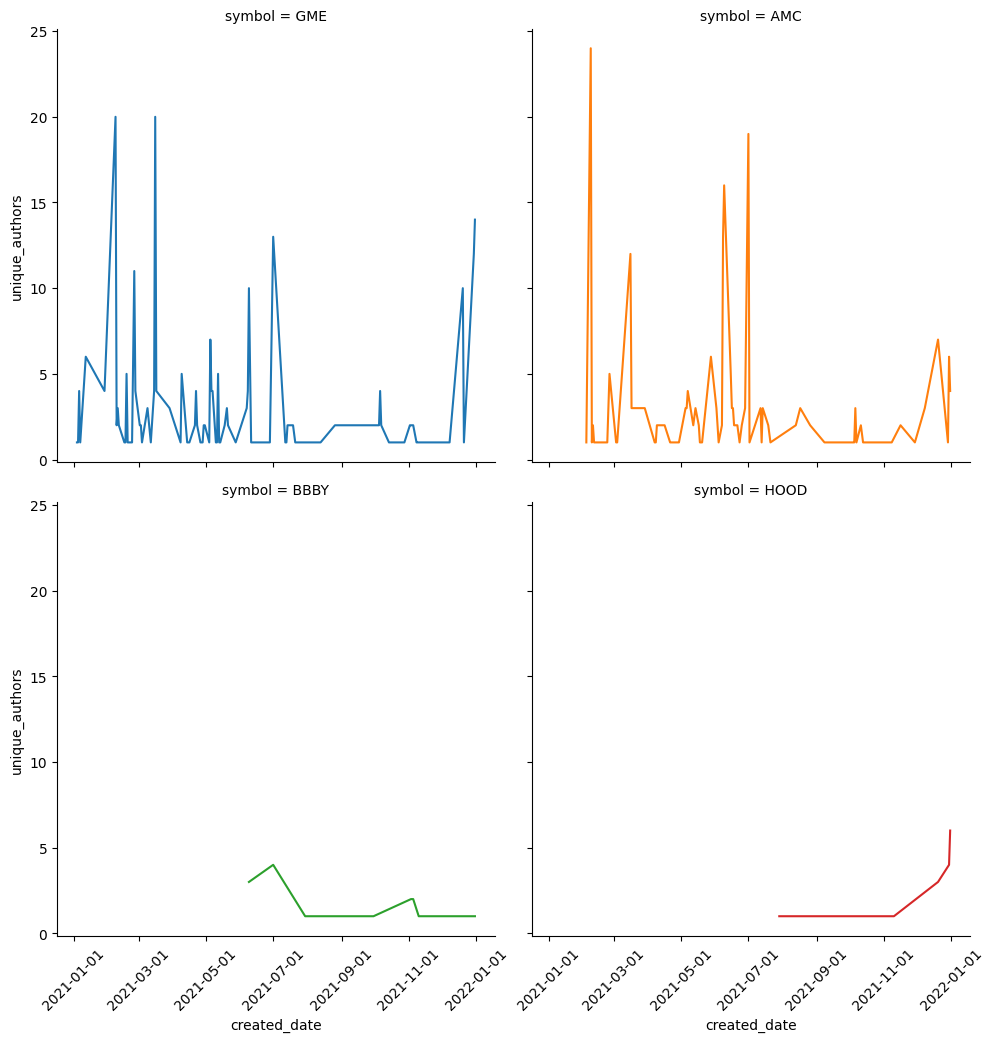

In [37]:
aggregated_2021 = utils.get_date_range(aggregated, "2021-01-01", "2022-01-01", "created_date")
draw_time_series_posters(aggregated_2021)

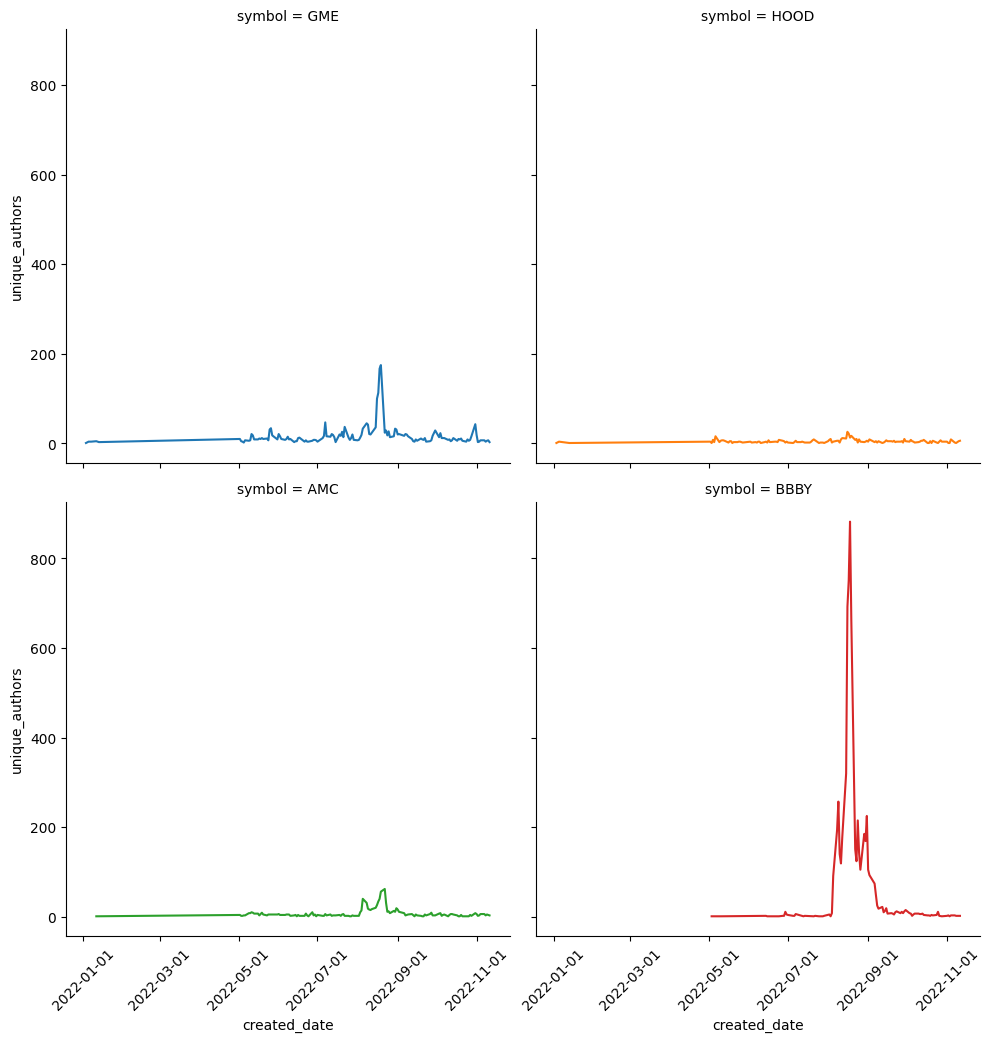

In [38]:
aggregated_2022 = utils.get_date_range(aggregated, "2022-01-01", "2023-01-01", "created_date")
draw_time_series_posters(aggregated_2022)

In [39]:
def draw_time_series_sentiment(data: pd.DataFrame, score_column: str):
    """Draw a time series plot of sentiment data."""
    filtered_data = data[data["score_column"] == score_column]
    
    fig, ax = plt.subplots(figsize=(20, 6))
    plt.close()
    
    fig = sns.relplot(
        data=filtered_data,
        x="created_date", y="score", col="symbol", hue="symbol",
        kind="line", zorder=5, col_wrap=2,  legend=False,
    );

    for _, ax in fig.axes_dict.items():
        date_format = mdates.DateFormatter("%Y-%m-%d")
        ax.xaxis.set_major_formatter(date_format)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

        ax.tick_params(axis='x', labelrotation = 45)
        
    plt.savefig(f"./images/{score_column}.png")
    plt.show()

In [40]:
score_columns = [
    "vader_score_title", "roberta_score_title", "vader_score_post_text", "roberta_score_post_text"
]
symbols = ["GME", "AMC", "HOOD", "BBBY"]

data = build_sentiment_dataset(symbols, score_columns)

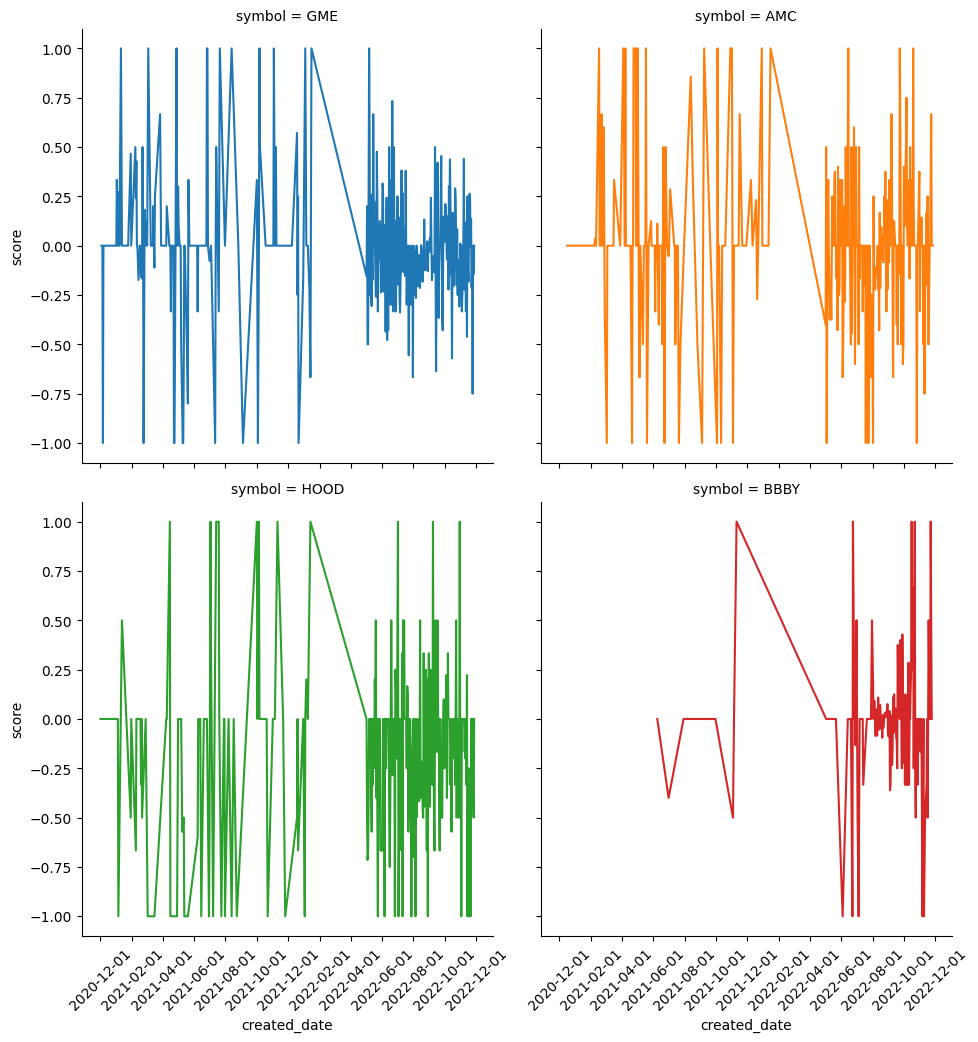

In [41]:
draw_time_series_sentiment(data, "roberta_score_title")